In [349]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rr_utils
import matplotlib.pyplot as plt
from torch.autograd import Variable
from io import StringIO
import torch.nn.functional as F
import torch.optim as optim
import emoji
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
import numpy as np
import nltk
import string
from nltk.stem import PorterStemmer
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
%matplotlib inline

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\1isad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\1isad\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1isad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [128]:
with open('yelp_labelled.txt', 'r') as file:
    text =file.read()

string_data = StringIO(text)
df = pd.read_csv(string_data, sep='\t')

In [134]:
df.head()

,Wow... Loved this place.,1
0,Crust is not good.,0
1,Not tasty and the texture was just nasty.,0
2,Stopped by during the late May bank holiday of...,1
3,The selection on the menu was great and so wer...,1
4,Now I am getting angry and I want my damn pho.,0


In [136]:
emoji_count = len([c for c in text if c in emoji.EMOJI_DATA])
non_ascii = [c for c in text if ord(c) > 127]
non_ascii_count = len(non_ascii)
scripts = {}
print(f"Emoji Count: {emoji_count}")
print(f"Unusual Characters: {non_ascii_count}")

Emoji Count: 3
Unusual Characters: 8


In [138]:
tokens = word_tokenize(text.lower())
tokens = [token for token in tokens if token not in string.punctuation and not token.isdigit()]

vocab= set(tokens)
vocab_size = len(vocab)

print(f"vocab size: {vocab_size}")
print(f"total words' {len(tokens)}")

vocab size: 2045
total words' 11083


In [106]:
# Calculating embedding dim as common rule of thumb
estimated_dim = min(50, int(vocab_size ** 0.25 * 10))
print(estimated_dim)

50


In [237]:
  # Split into sentences
sentences = re.split(r'[.!?]+', text)
sentences = [s.strip() for s in sentences if s.strip()]
    
    # Calculate sentence lengths (in words)
sentence_lengths = [len(word_tokenize(s)) for s in sentences]

median_length = np.median(sentence_lengths)
percentile = np.percentile(sentence_lengths, [75])

non_outliers = (percentile - median_length)*2 + median_length
non_outliers =int(non_outliers[0])
print(non_outliers)

21


In [160]:
#Lowercase
df  df.map(lambda x: x.lower() if isinstance(x, str) else x)
# Removing non-word characters
df = df.replace(to_replace=r'[^\w\s]', value='', regex=True)
#Removing digits
df = df.replace(to_replace=r'\d', value='', regex=True)

In [182]:
#Getting correct column name
first_col_name = df.columns[0] 
df['tokenized'] = df[first_col_name].apply(word_tokenize)

In [211]:
#Removing Stopwords
stop_words = set(stopwords.words('english'))
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
# Initialize the Porter Stemmer
stemmer = PorterStemmer()
# Define a function to perform stemming on the 'text' column
def stem_words(words):
    return [stemmer.stem(word) for word in words]
# Apply the function to the 'text' column and create a new column 'stemmed_text'
df['stemmed_text'] = df['tokenized'].apply(stem_words)

df.head()

In [239]:
# Create a vocabulary from the stemmed tokens
all_words = set(word for sentence in df['stemmed_text'] for word in sentence)
word_to_idx = {word: idx+1 for idx, word in enumerate(all_words)}  # +1 to reserve 0 for padding
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

sequences_list = df['int_sequences'].tolist()

padded_sequences = pad_sequences(
    sequences_list,
    maxlen=non_outliers,
    padding='post',
    truncating='post',
    value=0)

In [241]:
df.head()

,Wow... Loved this place.,1,tokenized,stemmed_text,int_sequences,padded_sequences
0,crust is not good,0,"[crust, good]","[crust, good]","[846, 1202]","[846.0, 1202.0]"
1,not tasty and the texture was just nasty,0,"[tasty, texture, nasty]","[tasti, textur, nasti]","[863, 1033, 1401]","[863.0, 1033.0, 1401.0]"
2,stopped by during the late may bank holiday of...,1,"[stopped, late, may, bank, holiday, rick, stev...","[stop, late, may, bank, holiday, rick, steve, ...","[1066, 1419, 472, 1607, 1470, 333, 468, 493, 320]","[1066.0, 1419.0, 472.0, 1607.0, 1470.0, 333.0,..."
3,the selection on the menu was great and so wer...,1,"[selection, menu, great, prices]","[select, menu, great, price]","[890, 1590, 1292, 1069]","[890.0, 1590.0, 1292.0, 1069.0]"
4,now i am getting angry and i want my damn pho,0,"[getting, angry, want, damn, pho]","[get, angri, want, damn, pho]","[288, 1581, 668, 1513, 425]","[288.0, 1581.0, 668.0, 1513.0, 425.0]"


In [243]:
print(df['padded_sequences'][0])

[ 846. 1202.]


In [291]:
# Train/test splits
X=np.array(padded_sequences)
y= df.iloc[:, 1]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

In [295]:
# Save training data
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

# Save validation data
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)

# Save test data
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

In [341]:
model = Sequential()
# Add embedding layer
embedding_dim = 50  # You can adjust this
model.add(Embedding(input_dim=vocab_size, 
                   output_dim=embedding_dim, 
                   ))

# Add LSTM layer
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add output layer - binary classification for sentiment
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [343]:
#early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    mode='min',             
    restore_best_weights=True)

#Checkpoint 
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [345]:
#Model Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,                  
    batch_size=32,
    callbacks=[early_stopping, checkpoint] 
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4933 - loss: 0.6940
Epoch 1: val_loss improved from inf to 0.69305, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.4934 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4760 - loss: 0.6944
Epoch 2: val_loss improved from 0.69305 to 0.69294, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4765 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4829 - loss: 0.6942
Epoch 3: val_loss improved from 0.69294 to 0.68909, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4834 - loss: 0.6941 - val_accuracy: 0.6200 - val_loss: 0.6891
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7064 - loss: 0.6075
Epoch 4: val_loss did not improve from 0.68909
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7094 - loss: 0.6039 - val_accuracy: 0.7133 - val_loss: 0.9898
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8763 - loss: 0.3912
Epoch 5: val_loss did not improve from 0.68909
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8773 - loss: 0.3882 - val_accuracy: 0.7133 - val_loss: 0.7851
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9045 - loss: 0.2592
Epoch 6: val_loss did not improve from 0.68909
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9048 - loss: 0.2590 - val_accuracy: 0.7200 - val_loss: 0.7710
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9617 - loss: 0.1388
Epoch 7: val_loss did not improve from 0.68909
22/22 ━━

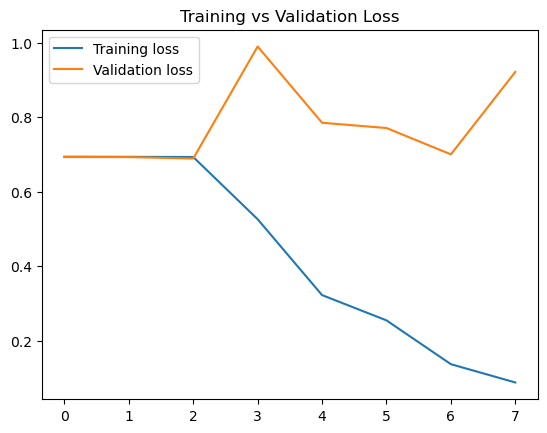

In [347]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

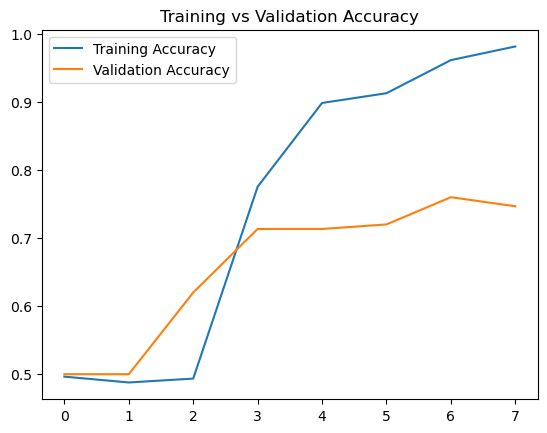

In [355]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [351]:
best_model = load_model('best_model.h5')

# Verify the model loaded correctly
best_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 21, 50)              │         102,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 194,029 (757.93 KB)

 Trainable params: 194,027 (757.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [359]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6029 - loss: 0.6896
Test accuracy: 0.6133
Test loss: 0.6893
